# Summary

This notebook provides a breath of all the features offered in the project. 

# Imports/Setup

In [1]:
from Data import dataset, generator
from Data import utility as data_utility
from Evaluation import utility as eval_utility
from Model import linear, scipy
from Model import utility as model_utility
from Objectives import losses

/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:68: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/libpyg.so: undefined symbol: _ZN3c1010Dispatcher17runRecordFunctionERN2at14RecordFunctionESt17reference_wrapperIKNS_14FunctionSchemaEENS_11DispatchKeyE
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: /data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_cluster/_version_cuda.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKSs
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/torch_geometric/typing.py:113: UserWarning: An issue occurred whil

In [2]:
class Config:
    # dataset
    batch_size = 64
    gen_size = 5
    mat_size = 5**2
    seed = 42
    
    # dataloader
    train_len = 1000
    valid_len = 100
    shuffle = True
    
    # device
    device_pref = 'cuda'
    device_ind = 0
    
    # model
    hidden = 256
    sparse_tol = 1e-2
    diagonal_bias = 0.1
    
    # loss
    l1 =  1e-5
    inv = 1e-5
    dev = 1.0
    cond = 1e-1
    
    # training
    epoches = 10
    lr = 1e-5
    verbose = True
    file_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/testing.pth'

In [3]:
data_utility.seed(Config.seed)

# Dataset/Dataloader

In [4]:
train_dataset_params = {
    'generator': generator.generate_2d_diffusion_spd,
    'norm_feat': data_utility.normalize_features,
    'epoch_len': Config.train_len,
    'batch_size': Config.batch_size,
    'size': Config.gen_size
}

valid_dataset_params = {
    'generator': generator.generate_2d_diffusion_spd,
    'norm_feat': data_utility.normalize_features,
    'epoch_len': Config.valid_len,
    'batch_size': Config.batch_size,
    'size': Config.gen_size
}

In [5]:
train_dataset = dataset.SystemDataset(**train_dataset_params)
valid_dataset = dataset.SystemDataset(**valid_dataset_params)

In [6]:
train_dataloader_params = {
    'dataset': train_dataset,
    'batch_size': Config.batch_size,
    'shuffle': Config.shuffle
}

valid_dataloader_params = {
    'dataset': valid_dataset,
    'batch_size': Config.batch_size,
    'shuffle': Config.shuffle
}

In [7]:
train_dataloader = dataset.get_dataloader(**train_dataloader_params)
valid_dataloader = dataset.get_dataloader(**valid_dataloader_params)

In [8]:
A, b = next(iter(train_dataloader))

Determinent: 16217257984.0
Matrix is non-singular.
Condition: 2285.30810546875


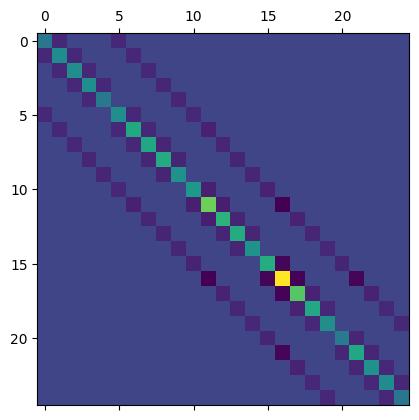

In [9]:
ind = 2
data_utility.check_singularity(A, ind)
data_utility.check_conditioning(A, ind)
data_utility.view_matrix(A, ind)

# Device

In [10]:
device_params = {
    'device_pref': Config.device_pref,
    'ind_dev': Config.device_ind
}

In [11]:
device = data_utility.set_device(**device_params)

Now using GPU.


# Model

In [12]:
model_params = {
    'n':Config.mat_size,
    'hidden':Config.hidden,
    'batch_size':Config.batch_size,
    'sparse_tol':Config.sparse_tol,
    'diagonal_bias':0
}

In [13]:
model = linear.FCN(**model_params).to(device)

# Loss Function

In [14]:
loss_params = {
    'l1': Config.l1,
    'inv': Config.inv,
    'dev': Config.dev,
    'cond': Config.cond,
    'batch_size': Config.batch_size,
    'size': Config.mat_size
}

In [15]:
criterion = losses.CondEyeDistance(**loss_params)

# Training

In [16]:
training_params = {
    'epoches': Config.epoches,
    'criterion': criterion,
    'train_loader': train_dataloader,
    'valid_loader': valid_dataloader,
    'model': model,
    'lr': Config.lr,
    'size': Config.mat_size,
    'batch_size': Config.batch_size,
    'device': device,
    'verbose': Config.verbose,
    'file_path': Config.file_path
}

In [ ]:
train_log, valid_log = model_utility.shared_training_loop(**training_params)

Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0, Train: 0.999072027027607, Valid: 0.7757942187786102


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1, Train: 0.721427230477333, Valid: 0.6697993957996369


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2, Train: 0.6454143621325493, Valid: 0.6308210277557373


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3, Train: 0.621347546339035, Valid: 0.6120230156183243


Train:   0%|          | 0/1000 [00:00<?, ?it/s]

Valid:   0%|          | 0/100 [00:00<?, ?it/s]

# Evaluation

In [ ]:
plot_training_params = {
    'train_log': train_log,
    'valid_log': valid_log,
    'title': 'EX', 
    'file_path': 'ex.png'
}

In [ ]:
eval_utility.plot_training(**plot_training_params)

In [ ]:
eval_instance_params = {
    'A': next(iter(valid_dataloader))[0],
    'model': model,
    'ind': 0,
    'size': Config.mat_size,
    'batch_size': Config.batch_size,
    'device': device,
    'file_path': 'ex.png'
}

In [ ]:
eval_utility.inspect_instance(**eval_instance_params)

# Model Save/Load

In [42]:
file_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/testing.pth'

In [43]:
model_utility.save_model(model, file_path)

In [44]:
model_utility.load_model(model, file_path)

/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/Model/utility.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(sta

# Training Logs Save/Load

In [45]:
log_path = '/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/logs.npz'

In [46]:
eval_utility.save_logs(train_log, valid_log, log_path)

Logs saved to: /data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/logs.npz


In [47]:
train_log, valid_log = eval_utility.read_logs(log_path)

Logs read from: /data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS/logs.npz


# Traditional Preconditioners

In [48]:
import numpy as np

In [49]:
data = next(iter(valid_dataloader))[0].numpy()
ind = 0

In [50]:
trad_precond_params = {
    'batch_matrix': data, 
    'ind': ind, 
    'fill_factor': 1, 
    'max_levels': 10, 
    'strength': 'classical'
}

The preconditioners converge on the block diagonal but is there any other patterning. It also looks like these have a strong main diagonal but the learned representation from the model has a weak diagonal.

/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/Model/scipy.py:16: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spla.spilu(A, fill_factor)
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/pyamg/aggregation/aggregation.py:215: SparseEfficiencyWarning: Implicit conversion of A to CSR
  warn('Implicit conversion of A to CSR', SparseEfficiencyWarning)


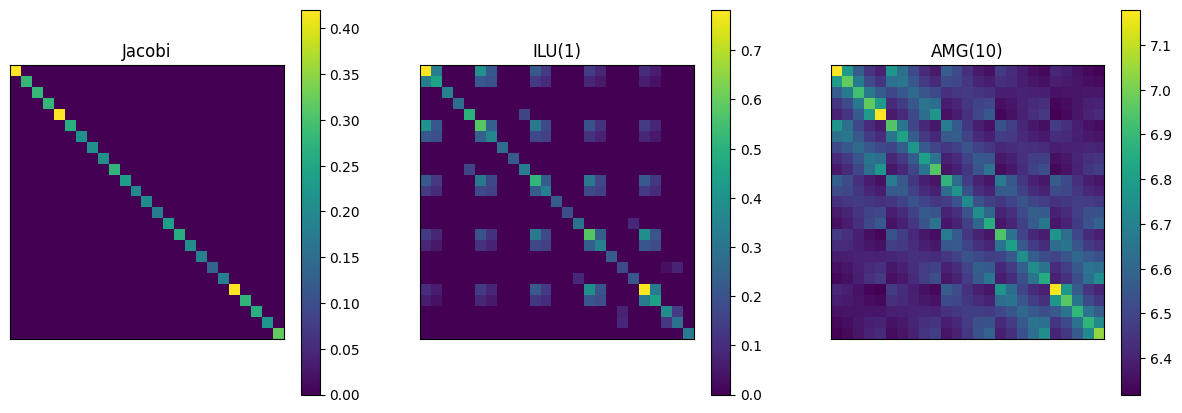

In [51]:
jac, ilu, amg = scipy.get_traditional_preconditioners(**trad_precond_params)

In [52]:
scipy.check_conditioning(data, np.eye(25), 0)
scipy.check_conditioning(data, jac, 0)
scipy.check_conditioning(data, ilu, 0)
scipy.check_conditioning(data, amg, 0)

Condition: 4052.4207300105154
Condition: 4101.16431817365
Condition: 2715.4129997751756
Condition: 25.000000019119952
